# Cultivar Analysis

The script below imports cultivar datasets and uses the max. yield to generate model outputs. 

Last updated: 22 June 2020

In [1]:
# import packages and set working directory
import numpy as np
import matplotlib.pyplot as plt
import os
from math import exp
import pandas as pd
import seaborn as sns
import proplot as plot
import sys
import datetime
import matplotlib.colors as colors
import matplotlib.cm as cmx

# We need to add the module path to our system path so 
# so that our notebook can find our local objects and code:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import CropModel
from farm.functions import *

# set background color
plot.rc['figure.facecolor'] = 'white'
plot.rc.axesfacecolor = 'white'

## 1. Functions

In [2]:
# TODO: move this to functions

def run_model(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 21 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress) for df in o]
    
    return x, total_rf

## 2. Run simulations

In [3]:
# Run simulations for certain cultivars (days to maturity)

#varieties = [70, 90, 110, 130, 150, 190, 210, 230]
varieties = np.arange(70,220,5)

result = []

for i in varieties:
    # note: bumping up to 200 sims per cultivar type takes several minutes to run
    # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
    data, rf = run_model(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
    df['RF'] = rf
    df['Cultivar'] = i
    result.append(df)
    
result = pd.concat(result)
result

,AvgStress,DynamicStress,Yield,RF,Cultivar
0,0.269104,0.489279,2175.670108,174.883439,70
1,0.249624,0.479796,2216.069428,192.654303,70
2,0.215145,0.167576,3546.124258,189.904131,70
3,0.213310,0.130192,3705.381792,272.888233,70
4,0.056691,0.041881,4081.587809,257.868565,70
...,...,...,...,...,...
95,0.227513,0.169771,3536.777264,551.088961,215
96,0.245114,0.158586,3584.422621,567.623394,215
97,0.212789,0.110004,3791.384968,656.553956,215
98,0.159560,0.108254,3798.836705,623.354564,215


In [5]:
# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this

def category(x):
    if x < 120:
        return "Early (< 120 d)"
    if 120 <= x <= 165:
        return "Medium (120 - 165 d)"
    else:
        return "Late (165 + d)"
    
for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))


In [6]:
# Make sure that there are the same number of outputs per grouping
result.Category.value_counts()

Late (165 + d)          1000
Medium (120 - 165 d)    1000
Early (< 120 d)         1000
Name: Category, dtype: int64

In [7]:
# Create bins for rainfall

# roughly how many groups if in 50 mm incremements?
print((result.RF.max() - result.RF.min())/50)

#labels = ['< 110 mm','110 - 160 mm','160 - 210 mm', '210 - 260 mm','260 - 310 mm', '310 - 360 mm', '360 - 410 mm', 
#          '410 - 460 mm','460 - 510 mm','510 - 560 mm', '560 - 610 mm','610 - 660 mm', '660 - 710 mm', '710 - 760 mm', 
#         '760 +']

# result['RF_bins'] = pd.cut(result.RF, 15, labels=labels) # 15 bins
result['RF_bins_orig'] = pd.cut(result.RF, 13) # labels aren't 100% accurate but okay for now
result.RF_bins_orig.value_counts()


16.066840194371743


(289.666, 351.462]    498
(227.871, 289.666]    480
(351.462, 413.258]    476
(413.258, 475.053]    393
(166.075, 227.871]    340
(475.053, 536.849]    299
(536.849, 598.644]    183
(104.28, 166.075]     183
(598.644, 660.44]      80
(660.44, 722.235]      34
(41.681, 104.28]       25
(722.235, 784.031]      7
(784.031, 845.826]      2
Name: RF_bins_orig, dtype: int64

## 3. Box plot and Joint PDF

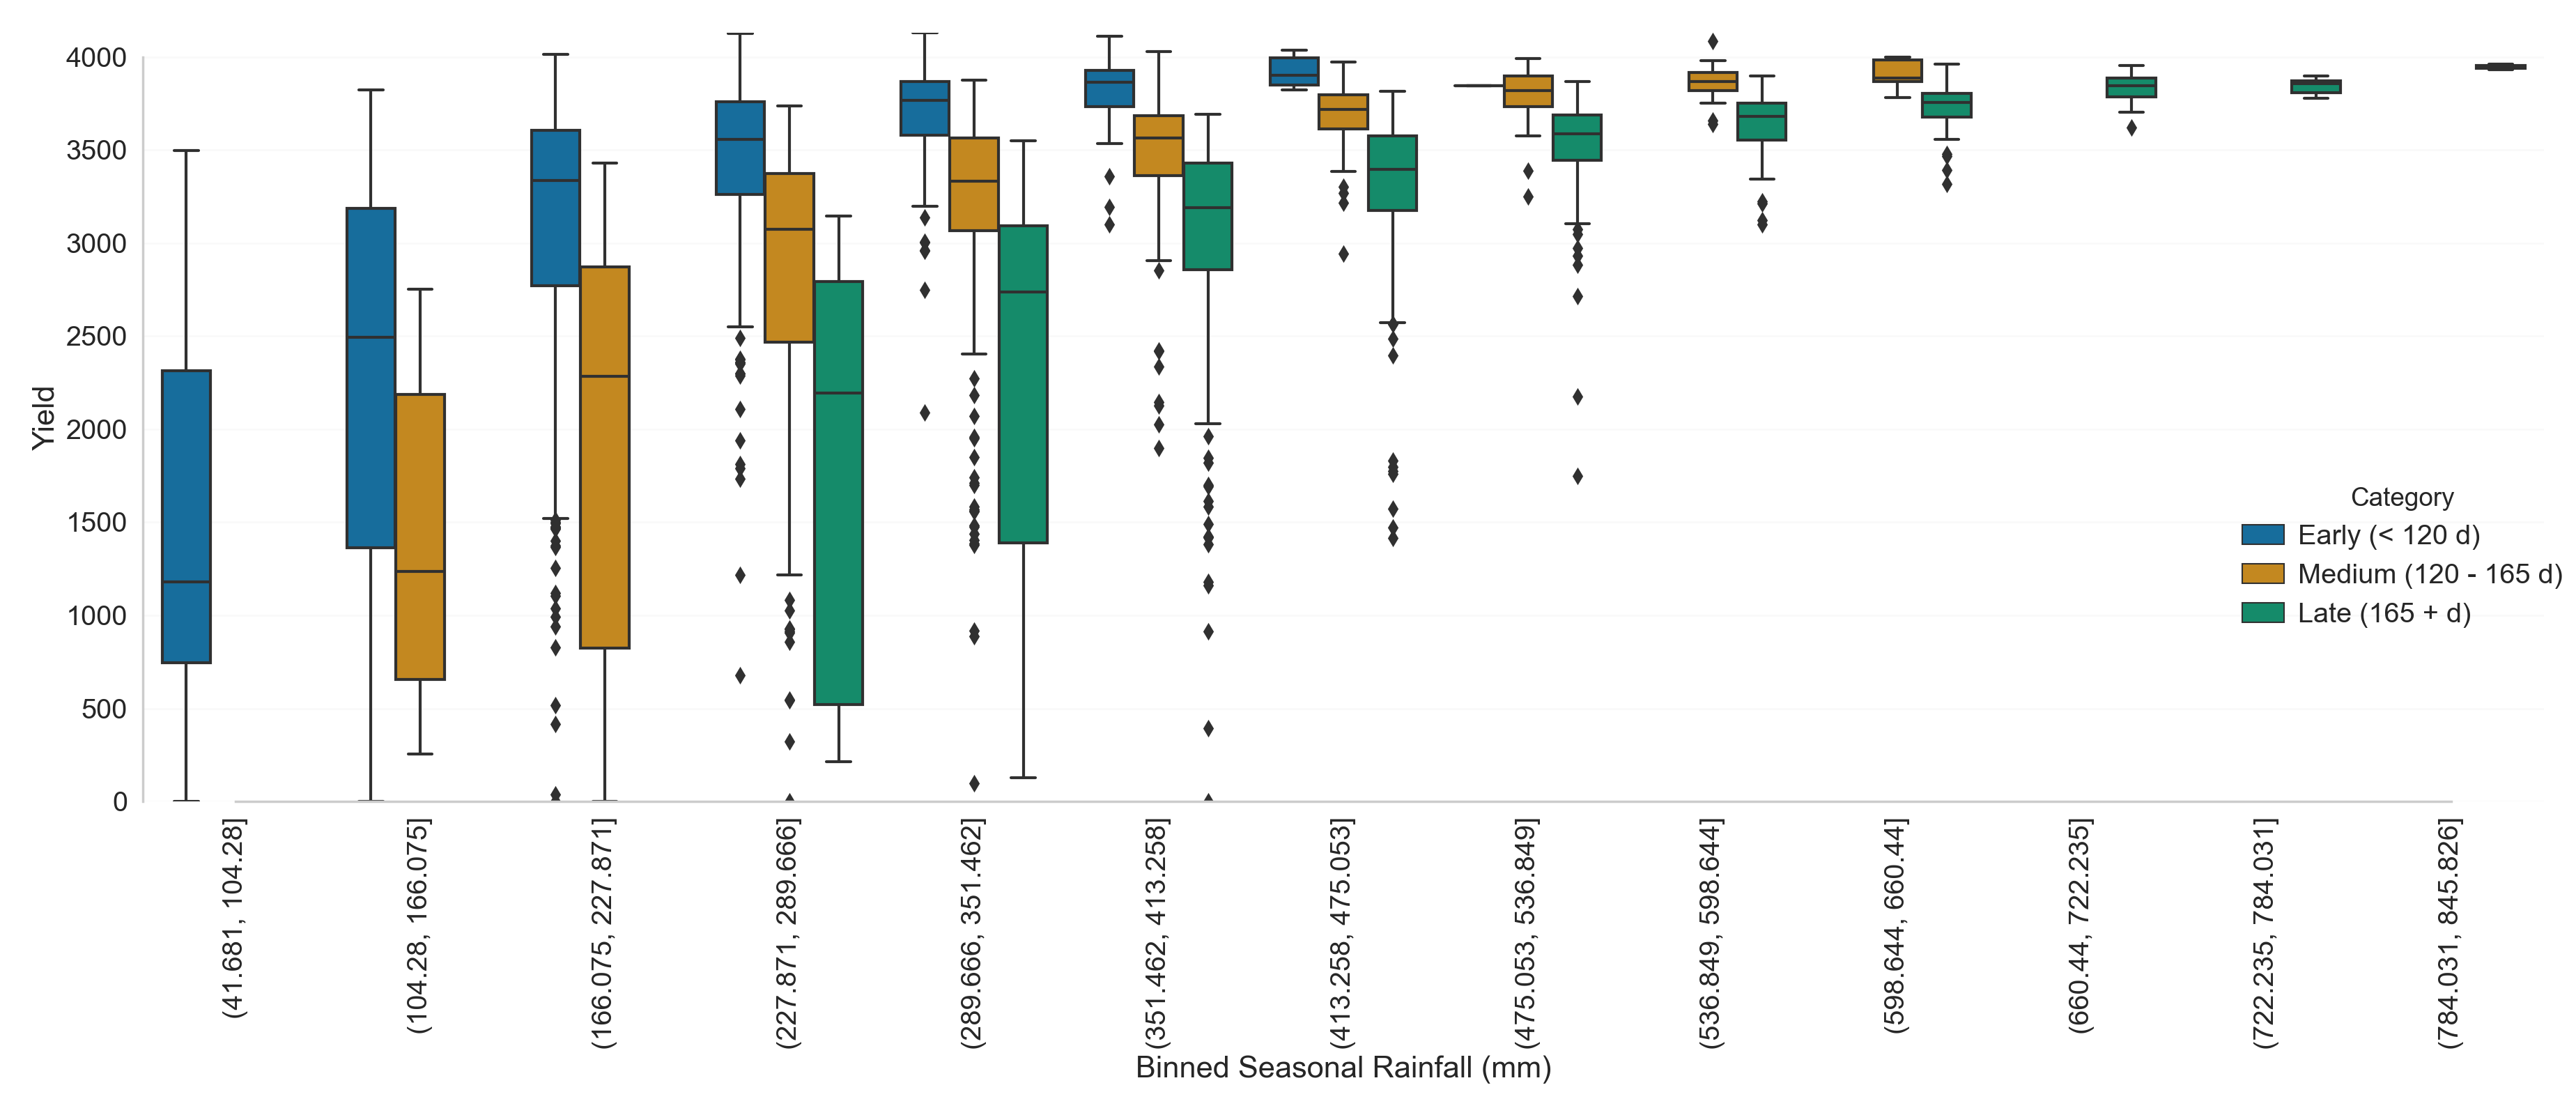

In [8]:
# Make box plot with yield statistics
# Note: to have better labels just edit the labels in the previous cell

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("colorblind") #blues bhm green3 reds colorblind set3

g = sns.catplot(x="RF_bins_orig", y="Yield", hue="Category", data=result, kind="box", height=8, aspect=2) # height=15, aspect=8
g.set_axis_labels("Binned Seasonal Rainfall (mm)") # , ""
g.despine(trim=True)
plt.setp(g.ax.get_xticklabels(), rotation=90);
plt.tight_layout()

In [ ]:

births_by_date.plot(ax=ax)

# Add labels to the plot
style = dict(size=10, color='gray')

ax.text('2012-1-1', 3950, "New Year's Day", **style)


### Actually make the max yield based on empirical relationship

### Heat check on whether these values are reasonable. 

Two parts:
    
1. Add in more maize varieties to see if the linear regression holds -- looks fine
2. Compare with external datasets for relative validation -- EWX & Frank's paper. We could reduce the max value by 50% to be more realistic. Or look at our yield data.. Just quickly going to do that. 

0.8821342568671495
m 0.03820972194249297
b -2.572222327532083
0.3905396783804279
m 0.01875098888679605
b 0.29946317573930376


<Figure size 500x400 with 0 Axes>

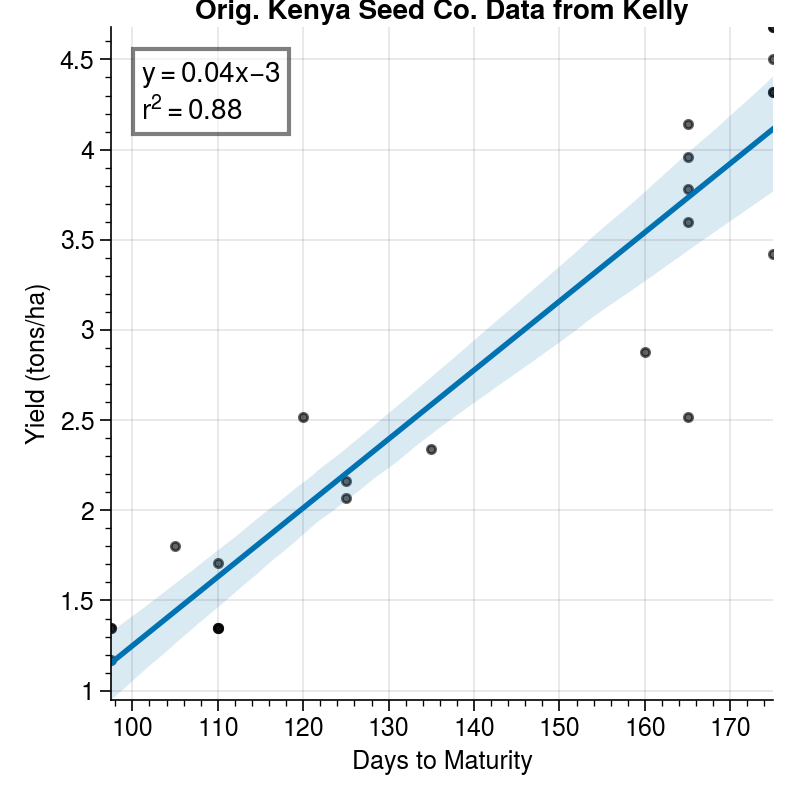

<Figure size 500x400 with 0 Axes>

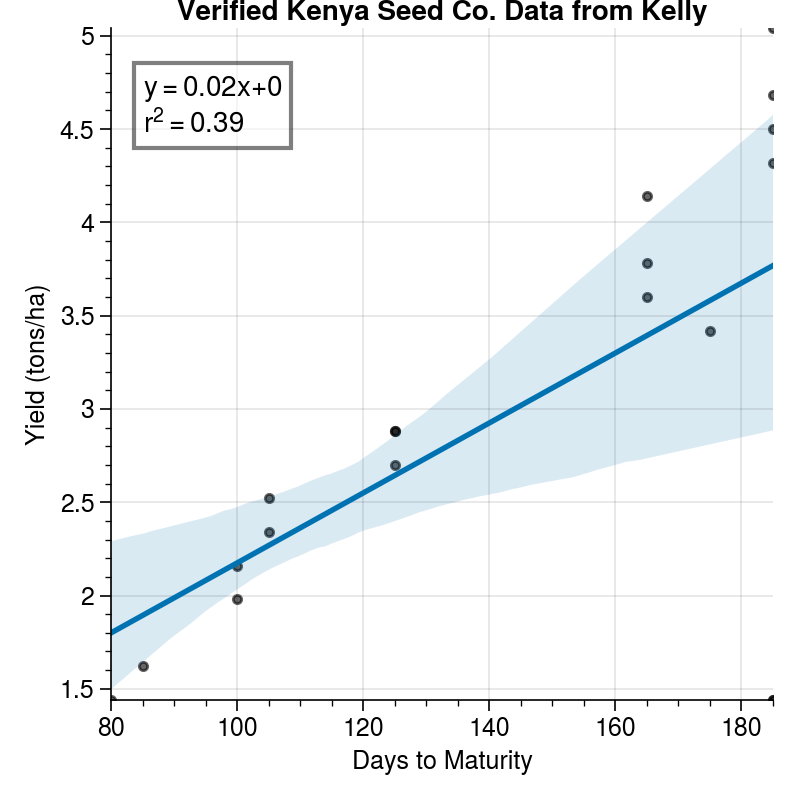

In [11]:
# call in that figure to check 

# Original data
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields.csv')

# convert to metric tons
hybrid_data['yield_metric_tons'] = hybrid_data.yield_kg_ha/1000
hybrid_data

#sns.set(font_scale=1)
#sns.set_style("whitegrid")

p, m, b = plot_lin_regression(hybrid_data.days_to_maturity, hybrid_data.yield_metric_tons, 'days_to_maturity', 'yield_metric_tons', hybrid_data, 101, 4.5, 'Days to Maturity', 'Yield (tons/ha)', 
                    'Orig. Kenya Seed Co. Data from Kelly', positive=False)

# verified using Kenya Seed Co. - https://web.archive.org/web/20190819125927/http://kenyaseed.com/gallery/maize/
verified_hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_verified.csv')
verified_hybrid_data


# convert to metric tons
verified_hybrid_data['yield_metric_tons'] = verified_hybrid_data.verified_yield_kg_acre/1000
verified_hybrid_data

p, m, b = plot_lin_regression(verified_hybrid_data.verified_days_to_maturity, verified_hybrid_data.yield_metric_tons, 
                              'verified_days_to_maturity', 'yield_metric_tons', verified_hybrid_data, 
                              85, 4.8, 'Days to Maturity', 'Yield (tons/ha)', 
                              'Verified Kenya Seed Co. Data from Kelly', positive=True)

In [17]:
# what's the max yield
hybrid_data.yield_metric_tons.min()

1.2845

0.8040310879769121
m 0.027790555171045016
b -0.8277162088258405
0.6109750761024614
m 0.022698167046130428
b -0.11460070582872361


(0.6109750761024614, 0.022698167046130428, -0.11460070582872361)

<Figure size 500x400 with 0 Axes>

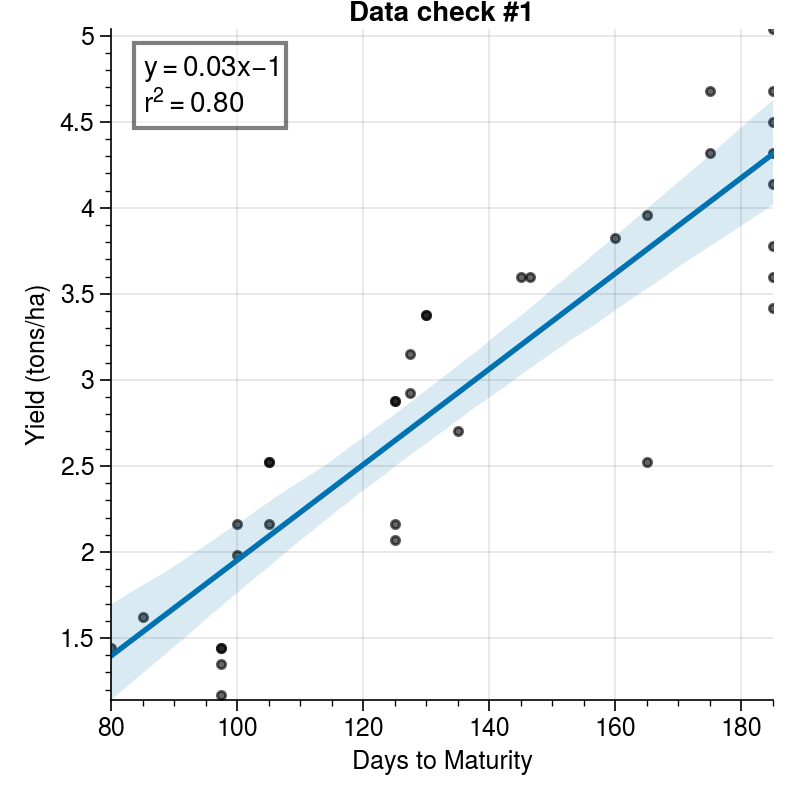

<Figure size 500x400 with 0 Axes>

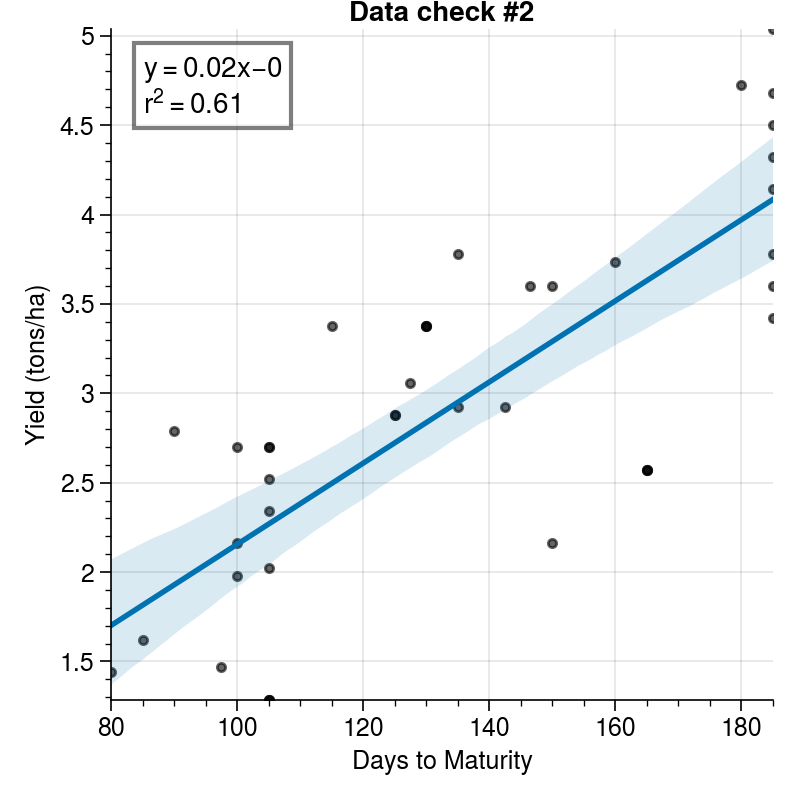

In [13]:
hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_v2.csv',usecols = ['Variety','Yield_kg_acre','DTM_Avg']).dropna()

# convert to metric tons
hybrid_data['yield_metric_tons'] = hybrid_data.Yield_kg_acre/1000
hybrid_data

plot_lin_regression(hybrid_data.DTM_Avg, hybrid_data.yield_metric_tons, 'DTM_Avg','yield_metric_tons', hybrid_data, 85, 4.9,'Days to Maturity', 'Yield (tons/ha)', 
                    'Data check #1', positive=False)

# Third group of varieties

hybrid_data = pd.read_csv('../data/Yields/hybrid_yields_v3.csv', usecols = ['VARIETY','Yield_kg_acre','Avg_DTM']).dropna()

# convert to metric tons
hybrid_data['yield_metric_tons'] = hybrid_data.Yield_kg_acre/1000
hybrid_data


hybrid_data
plot_lin_regression(hybrid_data.Avg_DTM, hybrid_data.yield_metric_tons, 'Avg_DTM','yield_metric_tons', hybrid_data, 85, 4.9,'Days to Maturity', 'Yield (tons/ha)', 
                    'Data check #2', positive=False)

Okay a couple of decisions here:
- Do we want the DTMs to go above 175? If so do we just make an assumption
- Is it okay to use the linear relationship rather than the data themselves
- Is 4680 kg/ha a reasonable max. value? Should this be lower.

In [32]:
def evolved_calc_yield(dtm=None, m = None, b = None):
    yield_kg_ha = m*dtm + b
    
    if dtm > 175:
        raise ValueError("days to maturity, {dtm} is larger than 175".format(
                dtm=dtm))
    if dtm < 68:
        raise ValueError("days to maturity, {dtm} is less than 68".format(
                dtm=dtm))
    
    return yield_kg_ha

evolved_calc_yield(100, m, b)
evolved_calc_yield(175,m,b)

4114.479012404177

In [49]:
# Have to re-create the run_model function so that in crop.calc_dstress it uses my evolved_calc_yield function

def run_model(n_sim = 500, station = 'OL JOGI FARM', texture = 'clay loam', lgp=180, pd_sim=60): 
    """ Run simulations for a specific climate, soil, and crop.

    Usage: total_rf_corr(n_sim, pd_ic, station, texture, lgp, pd_sim)
           
    Default values:
        n_sim = 500 # Number of Simulations to Remove Initial Conditions [integer]
        pd_ic = 1 # Planting Date for Initial Conditions [Julian day]
        station = 'OL JOGI FARM' # Climatology [string]
        texture = 'loam' # Soil Type [string]
        lgp = 180 # Length of Growing Period [Days]
        pd_sim 100 # Planting Date for Simulation [Julian day]

    """
    # Part 1. Set conditions for IC runs
    planting_date = pd_sim 

    # Part 2. Initialize model with a climate, soil and crop
    climate = Climate(station=station)
    soil = Soil(texture=texture)
    crop = Crop(soil=soil, lgp=lgp)
    soil.set_nZr(crop)

    model = CropModel(crop=crop, climate=climate, soil=soil)
    model.run()
    o = model.output()

    # Part 3. Get the mean, SD soil moisture and run the simulations to remove IC
    s0_mean, s0_std = average_soil_moisture(model, n_sims=n_sim, doy=planting_date)
    models = [CropModel(crop=crop, climate=Climate(), soil=soil) for i in np.arange(n_sim)]
    
    # Part 4. Run the actual simulations
    output = [model.run(s0=s0_mean, do_output=True, planting_date=planting_date) for model in models]

    # Part 5. Subset the growing period because model starts 21 days before planting
    start = 21 
    end = start + lgp

    # dont need this but helpful for debugging
    avg_stress = [df[start:end]['stress'].mean() for df in output]
    total_stress = [df[start:end]['stress'].sum() for df in output]
    total_rf = [df[start:end]['R'].sum() for df in output]
    avg_s = [df[start:end]['s'].mean() for df in output]
    o = output
    
    # Part 6. Output the dynamic stress and yield values
    x = [crop.calc_dstress(s=df.s, stress=df.stress, Y_MAX = evolved_calc_yield(i, m, b)) for df in o] # I have no clue whether this will work
    
    return x, total_rf


In [50]:
# Now I have to re-run the simulations using the max yields from this relationship

varieties = np.arange(75,180,5) # 21 is a better number to work with because it divides by three
len(varieties)

result = []

for i in varieties:
    # note: bumping up to 200 sims per cultivar type takes several minutes to run
    # whereas 100 sims where varieties = np.arange(70,200,5) takes less than a minute.
    data, rf = run_model(n_sim = 100, station = 'OL JOGI FARM', texture = 'clay loam', lgp=i, pd_sim=60)
    df = pd.DataFrame.from_records(data, columns =['AvgStress','DynamicStress','Yield'])
    df['RF'] = rf
    df['Cultivar'] = i
    result.append(df)
    
result = pd.concat(result)
result

,AvgStress,DynamicStress,Yield,RF,Cultivar
0,0.269351,0.202920,233.948401,135.768872,75
1,0.391996,0.712720,84.318690,111.703941,75
2,0.212895,0.178628,241.078314,211.687949,75
3,0.156264,0.152779,248.665148,223.856559,75
4,0.153129,0.098928,264.470717,151.450994,75
...,...,...,...,...,...
95,0.238937,0.188327,3339.610049,403.731678,175
96,0.287431,0.241378,3121.332547,401.621020,175
97,0.216141,0.163282,3442.659649,430.563609,175
98,0.302085,0.212392,3240.597536,358.411638,175


In [ ]:
# It worked! Okay not going to worry too much about it now, but might need Kelly's help refactoring into model

In [52]:
# Add categorical values for early, medium and late maturing
# There is probably a way more efficient way to do this

def category(x):
    if x < 110:
        return "Early (< 105 d)"
    if 110 <= x <= 140:
        return "Medium (110 - 140 d)"
    else:
        return "Late (145 + d)"
    
for row in result.Cultivar:
    result['Category'] = result.Cultivar.apply(lambda x: category(x))

result.Category.value_counts()

Early (< 105 d)         700
Late (145 + d)          700
Medium (110 - 140 d)    700
Name: Category, dtype: int64

In [54]:
# TODO check this but I might need rainfall to be grouped into equal bins?

# roughly how many groups if in 50 mm incremements?
print((result.RF.max() - result.RF.min())/50)

#labels = ['< 110 mm','110 - 160 mm','160 - 210 mm', '210 - 260 mm','260 - 310 mm', '310 - 360 mm', '360 - 410 mm', 
#          '410 - 460 mm','460 - 510 mm','510 - 560 mm', '560 - 610 mm','610 - 660 mm', '660 - 710 mm', '710 - 760 mm', 
#         '760 +']

# result['RF_bins'] = pd.cut(result.RF, 15, labels=labels) # 15 bins
result['RF_bins_orig'] = pd.cut(result.RF, 14) # labels aren't 100% accurate but okay for now
result.RF_bins_orig.value_counts()


14.192543995173235


(262.857, 313.545]    378
(212.169, 262.857]    355
(313.545, 364.232]    326
(364.232, 414.92]     288
(161.482, 212.169]    243
(414.92, 465.608]     188
(465.608, 516.295]    111
(110.794, 161.482]    105
(516.295, 566.983]     49
(59.397, 110.794]      29
(566.983, 617.671]     20
(617.671, 668.358]      4
(719.046, 769.734]      2
(668.358, 719.046]      2
Name: RF_bins_orig, dtype: int64

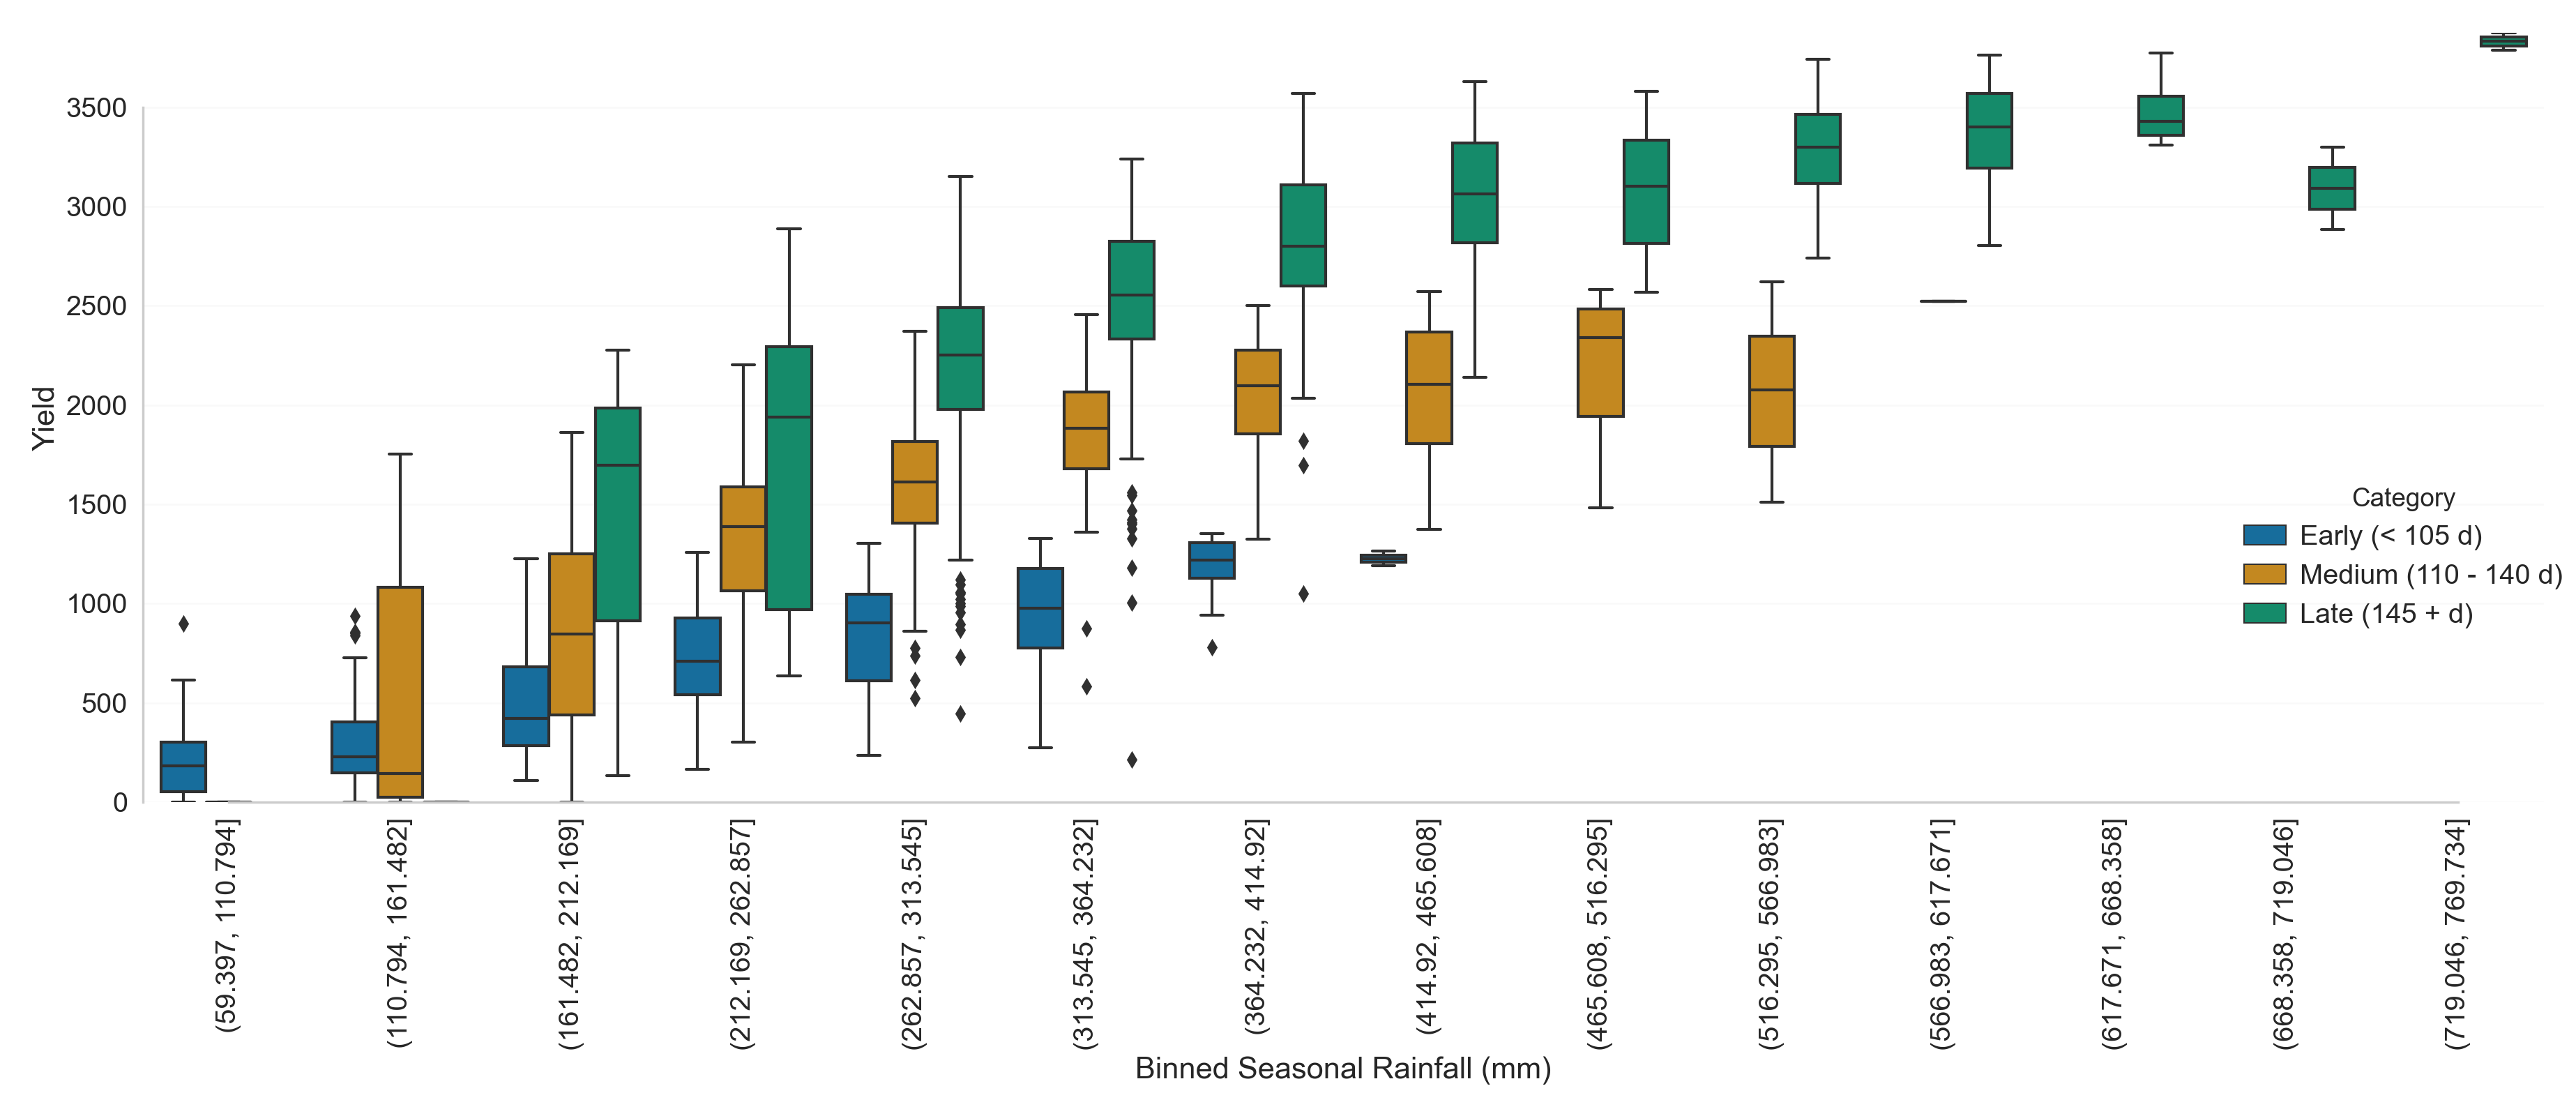

In [55]:
# Here's the box plot

sns.set(font_scale=1.3)
sns.set_style("whitegrid")
sns.set_palette("colorblind") #blues bhm green3 reds colorblind set3

g = sns.catplot(x="RF_bins_orig", y="Yield", hue="Category", data=result, kind="box", height=8, aspect=2) # height=15, aspect=8
g.set_axis_labels("Binned Seasonal Rainfall (mm)") # , ""
g.despine(trim=True)
plt.setp(g.ax.get_xticklabels(), rotation=90);
plt.tight_layout()

Text(680, 3300, 'late')

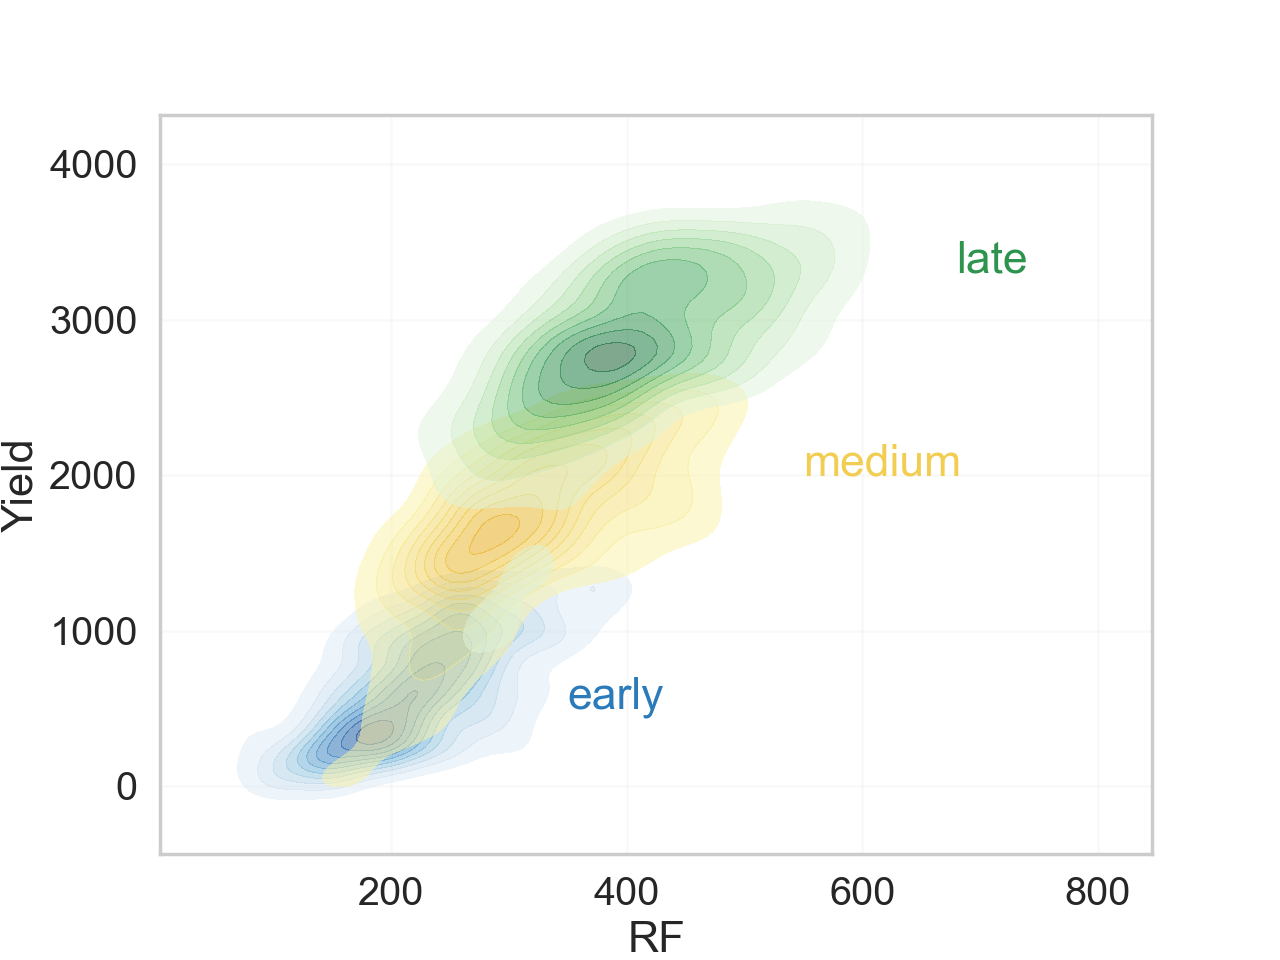

In [89]:
# 2D Density 
# code from here: https://seaborn.pydata.org/examples/multiple_joint_kde.html

result

# Subset the iris dataset by species
early = result.query("Category == 'Early (< 105 d)'")
med = result.query("Category == 'Medium (110 - 140 d)'")
late = result.query("Category == 'Late (145 + d)'")

# Set up the figure
f, ax = plt.subplots() # figsize=(15, 15)
#ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(early.RF, early.Yield, alpha=0.5,
                 cmap="blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(med.RF, med.Yield, alpha=0.5,
                 cmap="orange1", shade=True, shade_lowest=False)
ax = sns.kdeplot(late.RF, late.Yield, alpha=0.5,
                 cmap="greens", shade=True, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("greens")[-2]
yellow = sns.color_palette("orange1")[-3]
blue = sns.color_palette("blues")[-2]
ax.text(350,500, "early", size=16, color=blue)
ax.text(550,2000,"medium",size=16,color=yellow)
ax.text(680, 3300, "late", size=16, color=red)

### Additional Plots

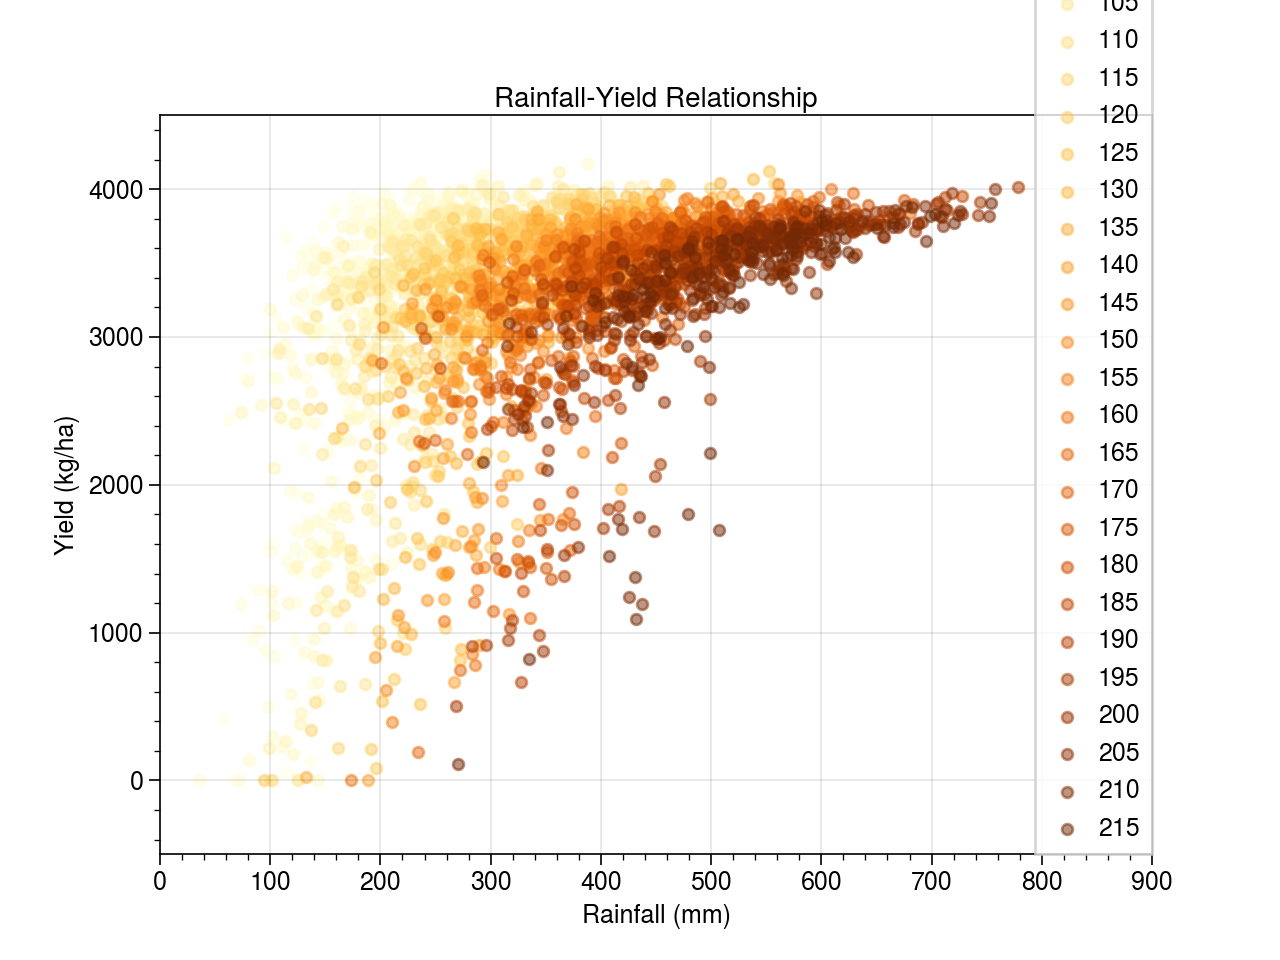

In [5]:
# Color scatter by cultivar

# Set up independent and dependent vars
x, y = result['RF'], result['Yield']

# Set the color map to match the number of species
z = range(1,len(varieties))
hot = plt.get_cmap('ylorbr')
cNorm  = colors.Normalize(vmin=0, vmax=len(varieties))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each cultivar
for i in range(len(varieties)):
    indx = result['Cultivar'] == varieties[i]
    plt.scatter(x[indx], y[indx], s=15, alpha=0.5,
                color=scalarMap.to_rgba(i), label=varieties[i])

plt.ylim(-500,4500)
plt.xlim(0,900)
plt.title('Rainfall-Yield Relationship')
plt.ylabel('Yield (kg/ha)') # Could change to yield normalized by max. yield
plt.xlabel('Rainfall (mm)')
plt.legend(loc='lower right')

Text(0.5, 1.0, 'Relationship between rainfall vs. yield of early, medium, late varieties')

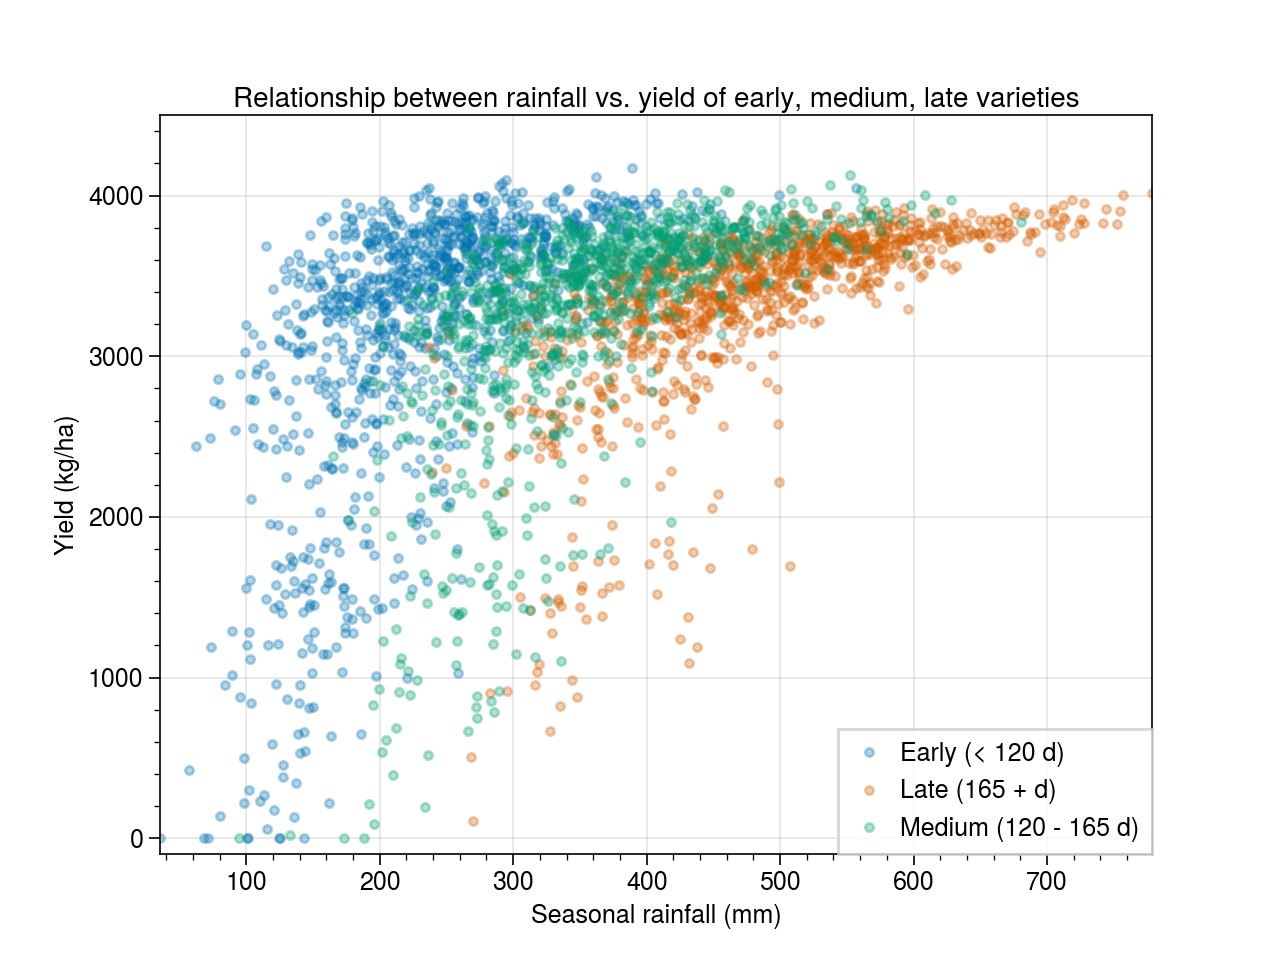

In [8]:
# Make another plot but based on categories
groups = result.groupby("Category")
for name, group in groups:
    plt.plot(group["RF"], group["Yield"], marker="o", linestyle="", label=name, alpha=0.3)
plt.legend()

plt.xlabel('Seasonal rainfall (mm)')
plt.ylabel('Yield (kg/ha)')
plt.ylim(-100,4500)
plt.title('Relationship between rainfall vs. yield of early, medium, late varieties')

(0.0, 4500.0)

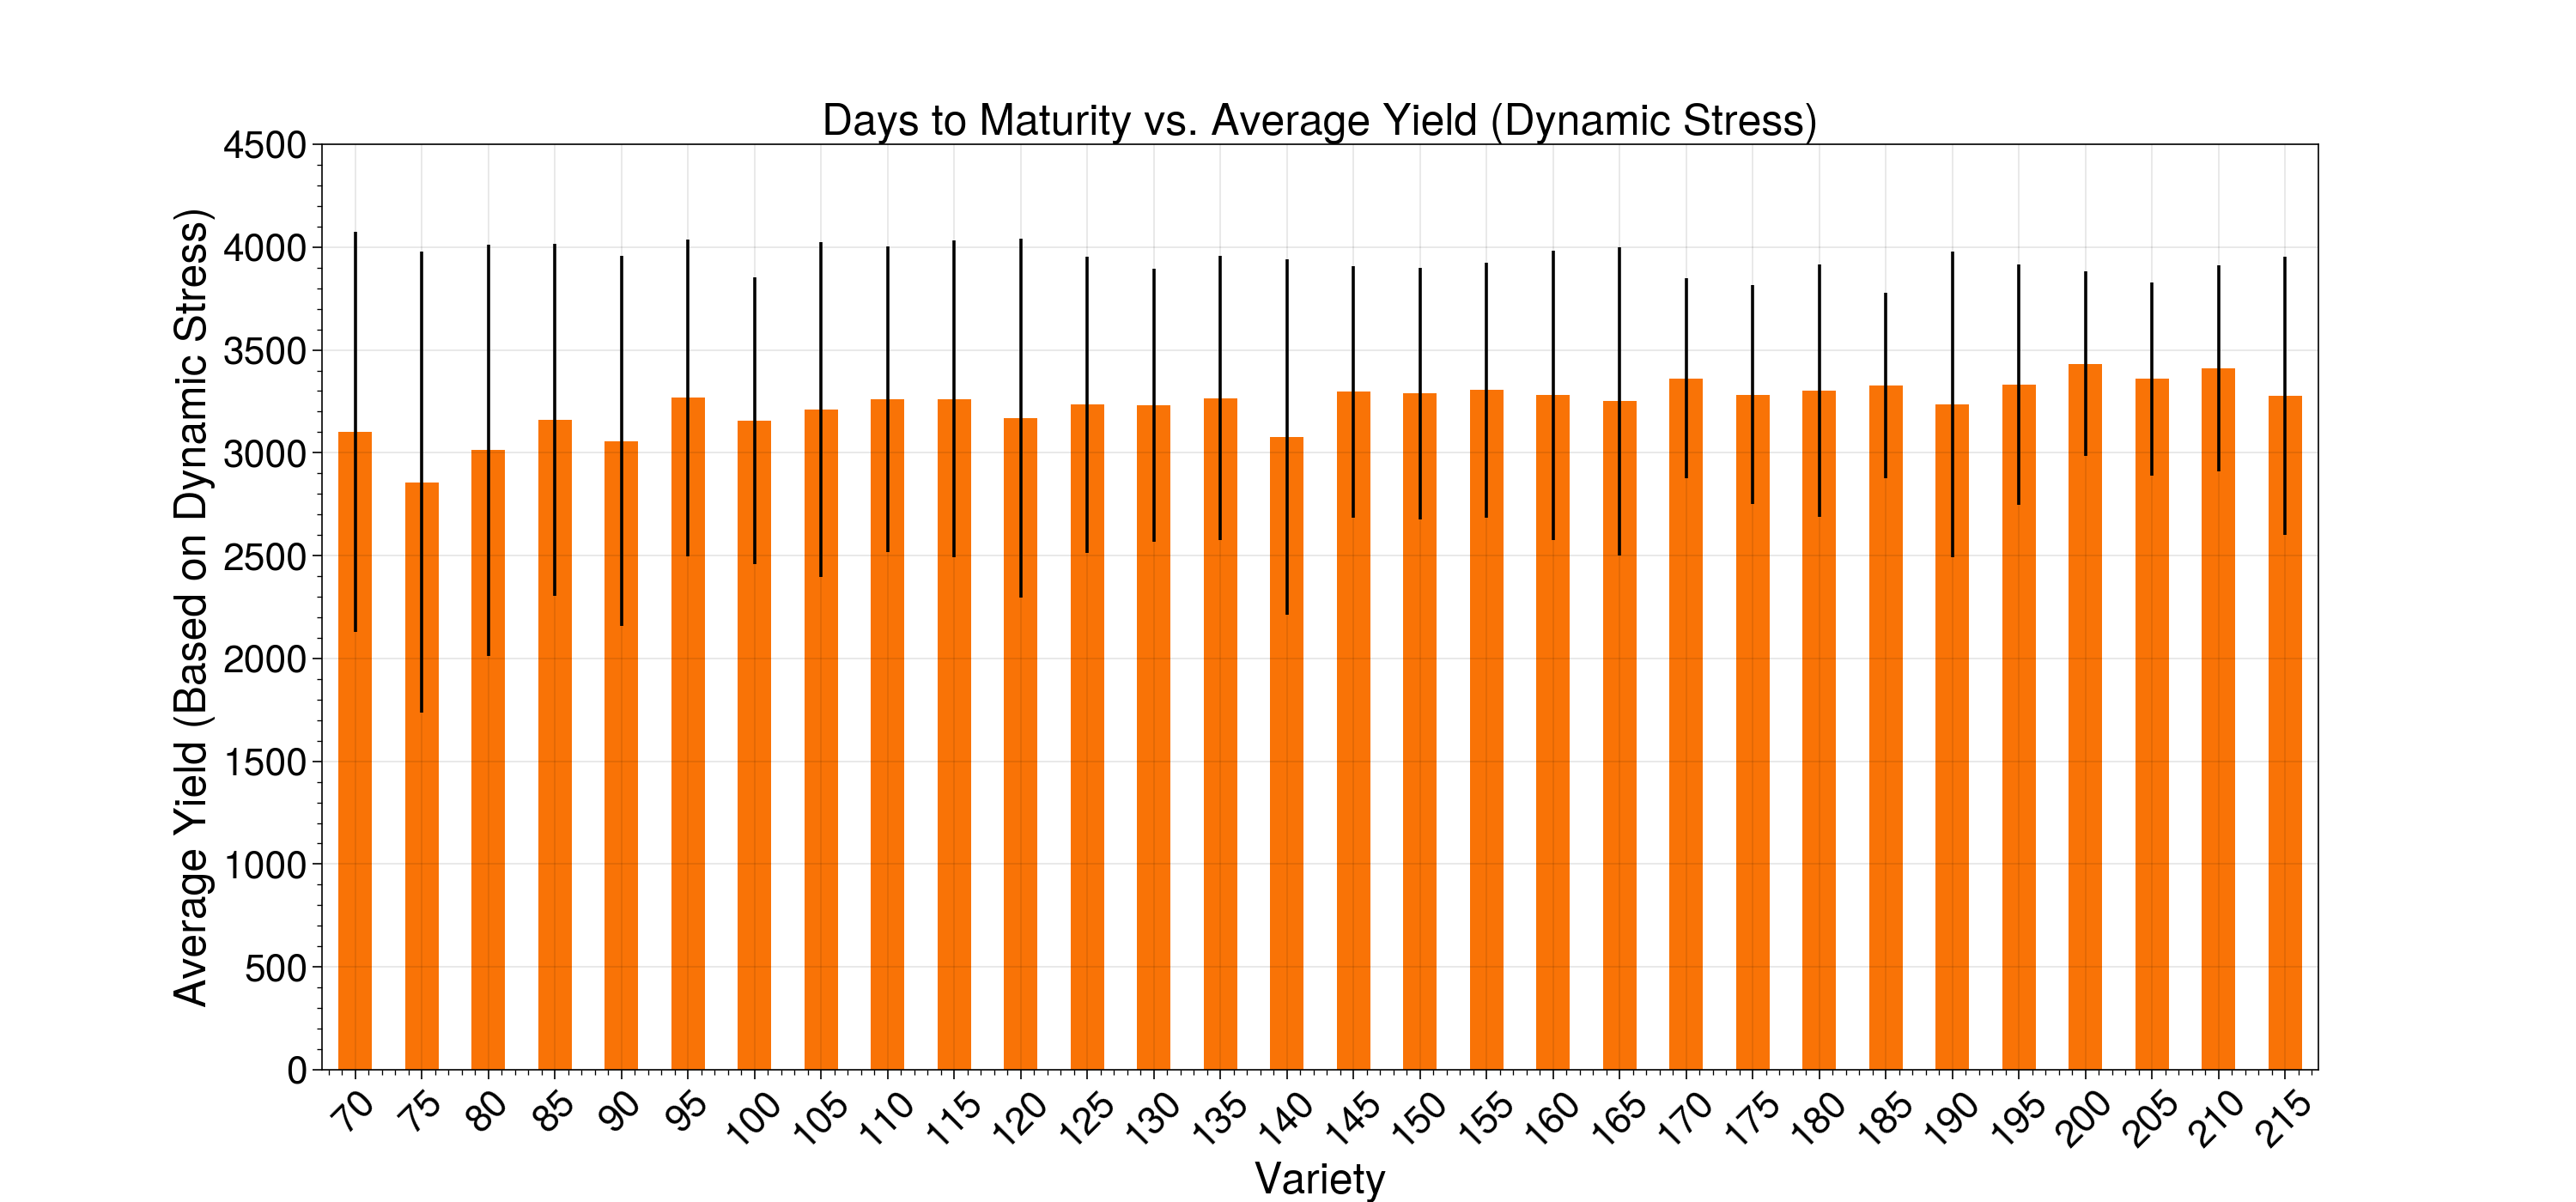

In [9]:
# Average yield per DTM

std = result.groupby('Cultivar')['Yield'].std()
result.groupby('Cultivar')['Yield'].mean().plot(figsize=(15,7),color='orange',legend=False,kind="bar",rot=45,fontsize=16,yerr=std) # color="blue",

plt.ylabel('Average Yield (Based on Dynamic Stress)', fontsize=18)
plt.xlabel('Variety', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Dynamic Stress)', fontsize=18)
plt.ylim((0,4500))

(0.0, 4500.0)

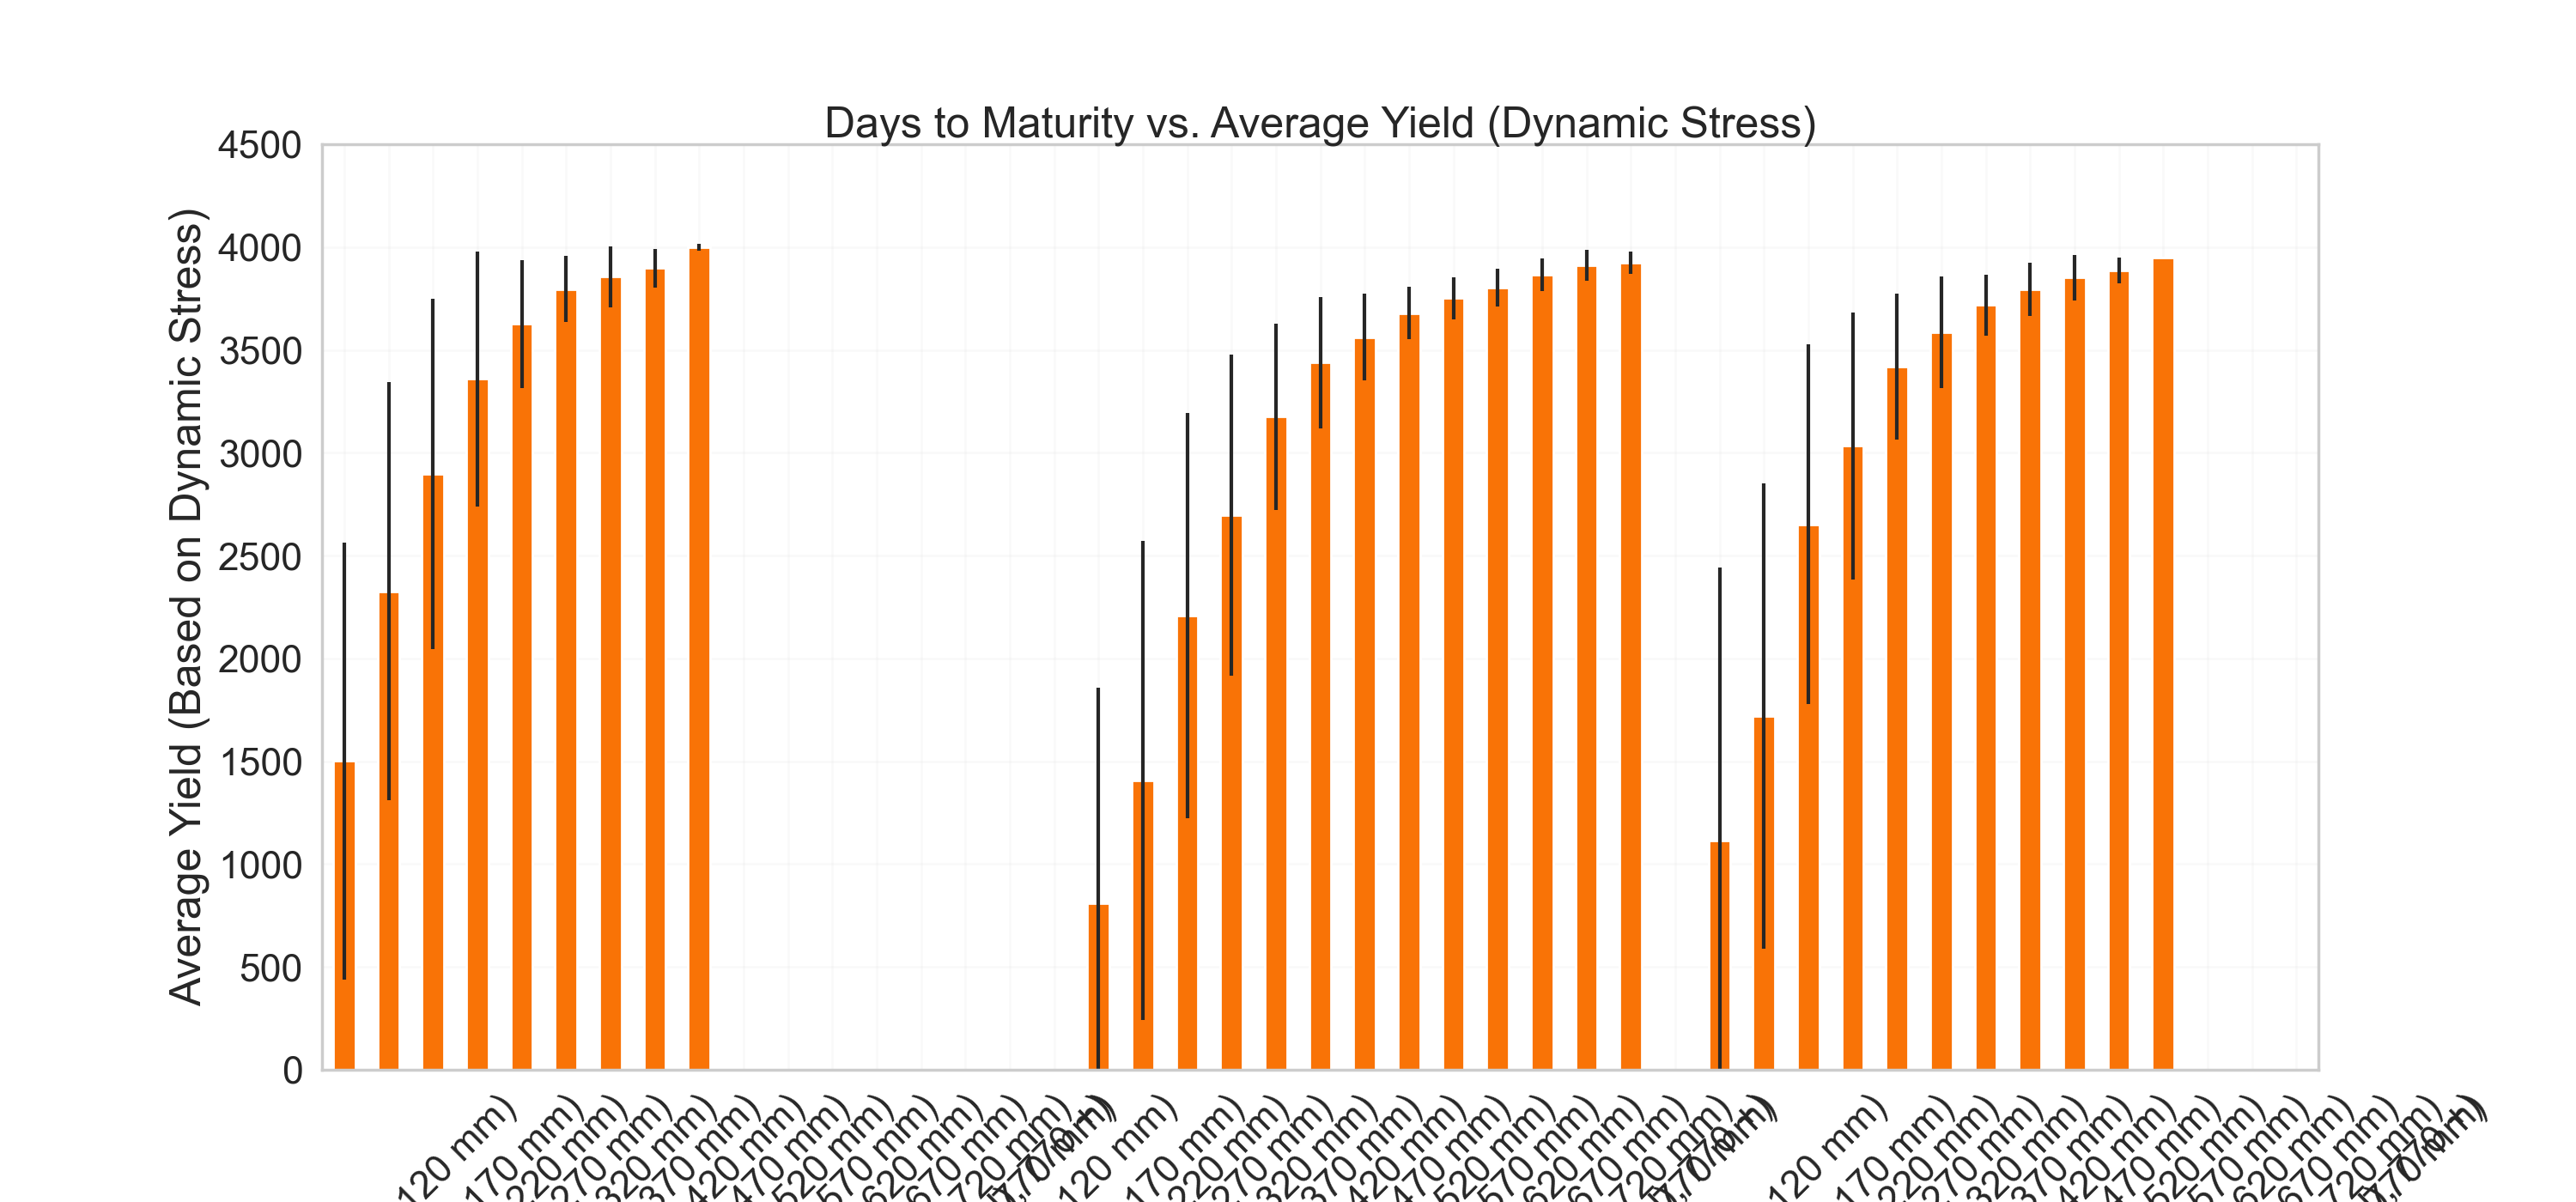

In [44]:
# groupby by RF_bins to get average

avg = result.groupby(['Category','RF_bins'])['Yield'].mean()
sd = result.groupby(['Category','RF_bins'])['Yield'].std()

avg.plot(figsize=(15,7),color='orange',legend=False,kind="bar",rot=45,fontsize=16,yerr=sd) # color="blue",

plt.ylabel('Average Yield (Based on Dynamic Stress)', fontsize=18)
plt.xlabel('Variety', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Dynamic Stress)', fontsize=18)
plt.ylim((0,4500))


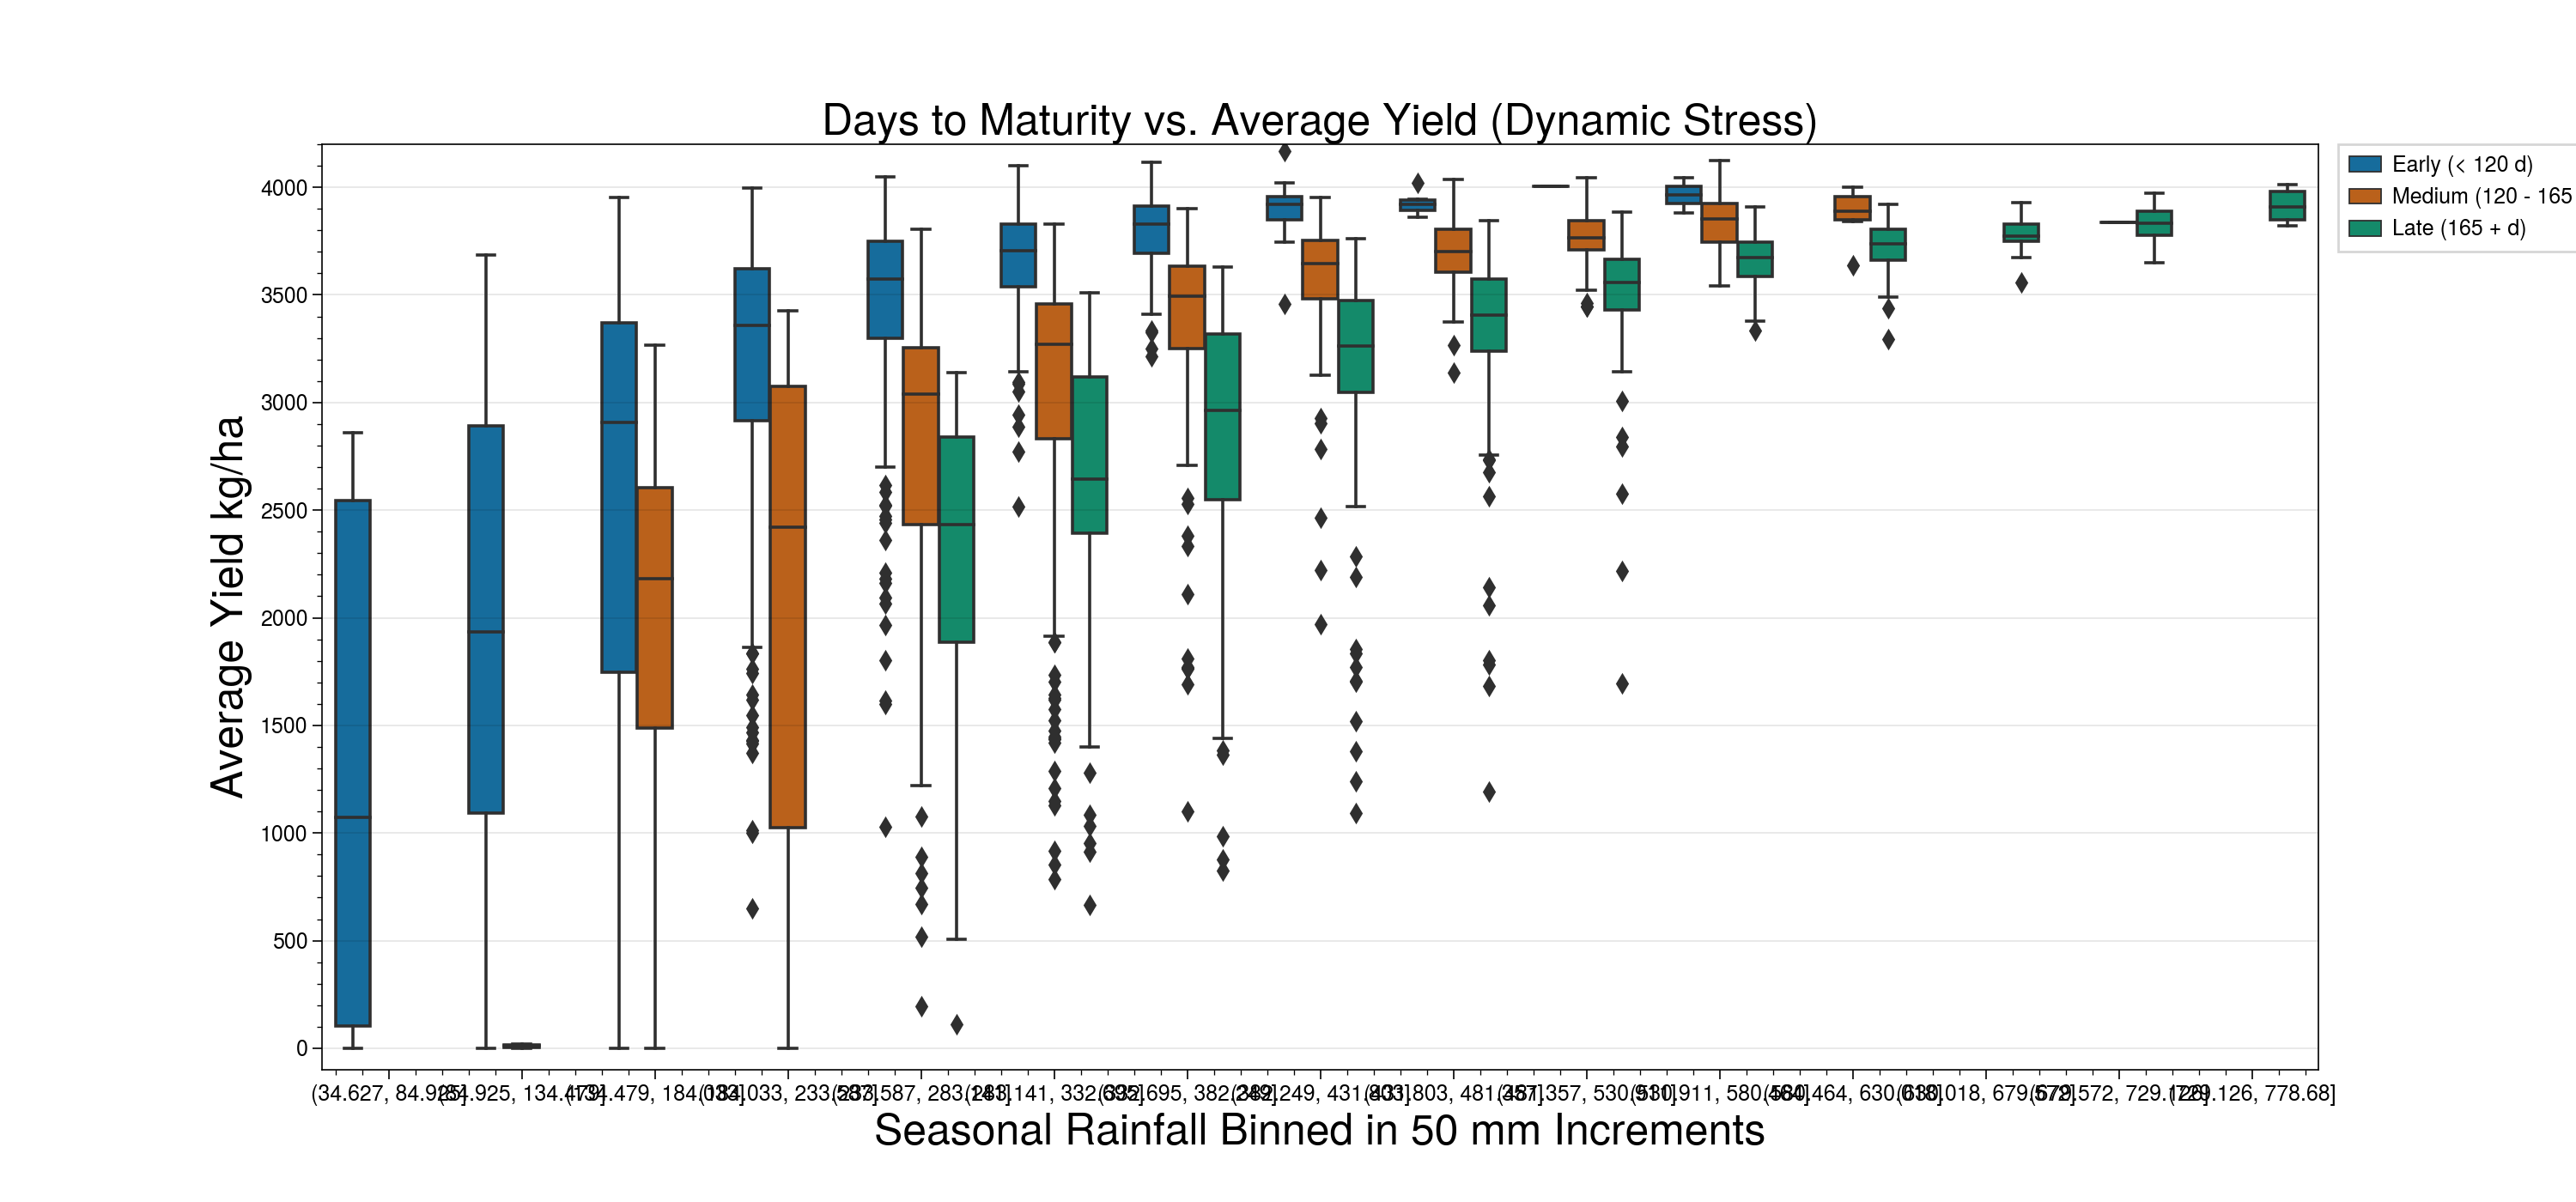

In [16]:
fig_dims = (15, 7)
fig, ax = plt.subplots(figsize=fig_dims)

ax = sns.boxplot(x="RF_bins_orig", y="Yield", hue="Category", data=result, ax=ax)
plt.ylabel('Average Yield kg/ha', fontsize=18)
plt.xlabel('Seasonal Rainfall Binned in 50 mm Increments', fontsize=18)
plt.title('Days to Maturity vs. Average Yield (Dynamic Stress)', fontsize=18)
plt.ylim((-100,4200))
plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
#ax = sns.swarmplot(x="RF_bins", y="Yield", hue="Category", data=result, color=".25")

# add median value - couldnt get this to work: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
medians = result.groupby(['Category','RF_bins_orig'])['Yield'].mean().median()
vertical_offset = result['Yield'].median() * 0.05 # offset from median for display

In [ ]:
# Previous Joint PDF plots



In [ ]:
# Set up independent and dependent vars
x, y = result['RF'], result['Yield']

y_ = y.values.reshape(3000,1) 
x_ = x.values.reshape(3000,1)


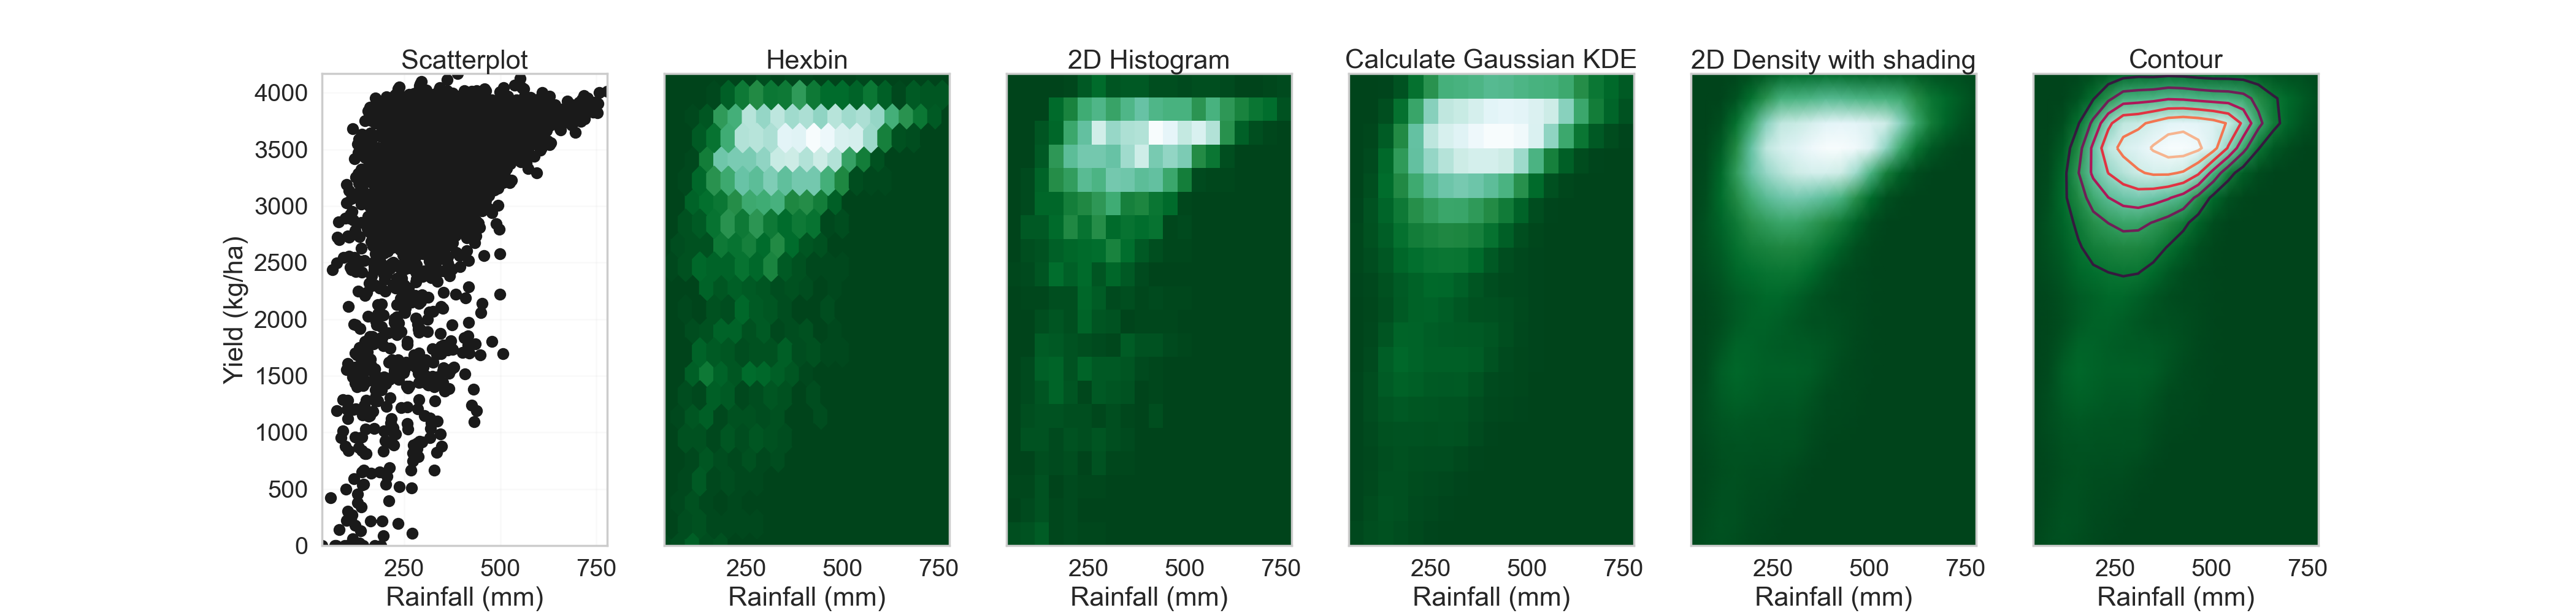

In [67]:
# Tutorial here: https://python-graph-gallery.com/86-avoid-overlapping-in-scatterplot-with-2d-density/

import scipy.stats as st

# set up data as a matrix
data = result[['RF','Yield']].values
x,y = data.T

# Custom colorscale for joint distribution
cubehelix_cs=[[0.0, '#fcf9f7'],
 [0.16666666666666666, '#edcfc9'],
 [0.3333333333333333, '#daa2ac'],
 [0.5, '#bc7897'],
 [0.6666666666666666, '#925684'],
 [0.8333333333333333, '#5f3868'],
 [1.0, '#2d1e3e']]

from scipy.stats import kde

# Create a figure with 6 plot areas
fig, ax = plt.subplots(ncols=6, nrows=1, figsize=(21, 5), sharex = True, sharey = True)

# add a big axes, hide frame
#a#xs = fig.add_subplot(161, frameon=False)

# Everything starts with a Scatterplot
ax[0].set_title('Scatterplot')
ax[0].plot(x, y, 'ko')
# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
ax[1].set_title('Hexbin')
ax[1].hexbin(x, y, gridsize=nbins, cmap=plt.cm.BuGn_r)

# 2D Histogram
ax[2].set_title('2D Histogram')
ax[2].hist2d(x, y, bins=nbins, cmap=plt.cm.BuGn_r)

# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde(data.T)
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# plot a density
ax[3].set_title('Calculate Gaussian KDE')
ax[3].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap=plt.cm.BuGn_r)
 
# add shading
ax[4].set_title('2D Density with shading')
ax[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
 
# contour
ax[5].set_title('Contour')
ax[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap=plt.cm.BuGn_r)
ax[5].contour(xi, yi, zi.reshape(xi.shape) )

for a in ax.flat:
    a.set(xlabel='Rainfall (mm)', ylabel='Yield (kg/ha)')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for a in ax.flat:
    a.label_outer()